# The effect of over-sampling and under-sampling on model calibration

This note book examines the effect of under-sampling or over-sampling (including SMOTE) to balance training examples for imbalanced data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import make_classification
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Generate data set

We will generate a set of data where 90% of examples are the negative class, and 10% the positive class.

In [2]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
        n_clusters_per_class=1, weights=[0.90, 0.10], class_sep=0.60, flip_y=0,
        hypercube=True, random_state=42)

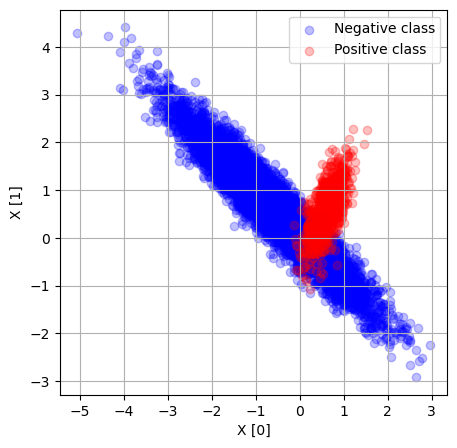

In [3]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot() 
mask = y == 0
ax.scatter (X[mask, 0], X[mask, 1], c='b', alpha=0.25, label='Negative class')
mask = y == 1
ax.scatter (X[mask, 0], X[mask, 1], c='r', alpha=0.25, label='Positive class')
ax.legend()
ax.set_xlabel('X [0]')
ax.set_ylabel('X [1]')
ax.grid()
plt.show()

### Split into training and test sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

## Fit models to original data, or data with oversampling or undersampling

### Fit model to original data balance

In [5]:
model = LogisticRegression()
model.fit(X_train, y_train)

# Get acuracy scores
print (f'ROC AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):0.3f}')
print (f'Recall: {recall_score(y_test, model.predict(X_test)):0.3f}')
print (f'Precision: {precision_score(y_test, model.predict(X_test)):0.3f}')

ROC AUC: 0.944
Recall: 0.623
Precision: 0.931


### Fit model to randomly undersampled majority data

Fitting the model to randomly undersampled majority data enhances recall (What proportion of actual positives was identified correctly?) at the cost of worsened precision (What proportion of positive identifications was actually correct?). Or in other words we identify more real positives, but at the cost of more false positives.

In [6]:
undersampler = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

model_undersampled = LogisticRegression()
model_undersampled.fit(X_undersampled,y_undersampled)

# Get acuracy scores
print (f'ROC AUC: {roc_auc_score(y_test, model_undersampled.predict_proba(X_test)[:,1]):0.3f}')
print (f'Recall: {recall_score(y_test, model_undersampled.predict(X_test)):0.3f}')
print (f'Precision: {precision_score(y_test, model_undersampled.predict(X_test)):0.3f}')

ROC AUC: 0.950
Recall: 0.837
Precision: 0.496


### Fit model to randomly oversampled majority data

Fitting the model to randomly oversampled majority data again enhances recall at the cost of worsened precision.

In [7]:
oversampler = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = oversampler.fit_resample(X_train, y_train)

model_oversampled = LogisticRegression()
model_oversampled.fit(X_oversampled,y_oversampled)

# Get acuracy scores
print (f'ROC AUC: {roc_auc_score(y_test, model_oversampled.predict_proba(X_test)[:,1]):0.3f}')
print (f'Recall: {recall_score(y_test, model_oversampled.predict(X_test)):0.3f}')
print (f'Precision: {precision_score(y_test,model_oversampled.predict(X_test)):0.3f}')

ROC AUC: 0.950
Recall: 0.845
Precision: 0.483


## Fit model to SMOTE over-sampled data

SMOTE creates synthetic data by hyrdising data points. Fitting the model to SMOTE oversampled minority data again enhances recall at the cost of worsened precision.

In [8]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

model_smote = LogisticRegression()
model_smote.fit(X_smote, y_smote)

# Get acuracy scores
print (f'ROC AUC: {roc_auc_score(y_test, model_smote.predict_proba(X_test)[:,1]):0.3f}')
print (f'Recall: {recall_score(y_test, model_smote.predict(X_test)):0.3f}')
print (f'Precision: {precision_score(y_test, model_smote.predict(X_test)):0.3f}')

ROC AUC: 0.950
Recall: 0.837
Precision: 0.490


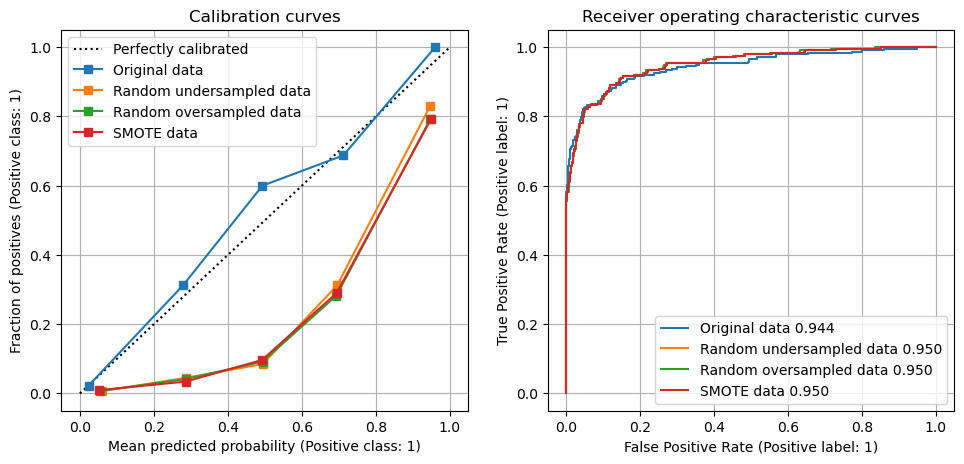

In [9]:
fig = plt.figure(figsize=(10,5))

# Calibration
ax1 = fig.add_subplot(121)
disp1 = CalibrationDisplay.from_estimator(
    model, X_test, y_test, ax=ax1, n_bins=5, label='Original data')
disp2 = CalibrationDisplay.from_estimator(
    model_undersampled, X_test, y_test, ax=ax1, n_bins=5, label='Random undersampled data')
disp3 = CalibrationDisplay.from_estimator(
    model_oversampled, X_test, y_test, ax=ax1, n_bins=5, label='Random oversampled data')
disp4 = CalibrationDisplay.from_estimator(
    model_smote, X_test, y_test, ax=ax1, n_bins=5, label='SMOTE data')
ax1.legend(loc='upper left')
ax1.set_title('Calibration curves')
ax1.grid()

# ROC
ax2 = fig.add_subplot(122)
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
disp1 = RocCurveDisplay.from_estimator(
    model, X_test, y_test, ax=ax2, label=f'Original data {auc:0.3f}')
auc = roc_auc_score(y_test, model_undersampled.predict_proba(X_test)[:,1])
disp2 = RocCurveDisplay.from_estimator(
    model_undersampled, X_test, y_test, ax=ax2, label=f'Random undersampled data {auc:0.3f}')
auc = roc_auc_score(y_test, model_oversampled.predict_proba(X_test)[:,1])
disp3 = RocCurveDisplay.from_estimator(
    model_oversampled, X_test, y_test, ax=ax2, label=f'Random oversampled data {auc:0.3f}')
auc = roc_auc_score(y_test, model_smote.predict_proba(X_test)[:,1])
disp4 = RocCurveDisplay.from_estimator(
    model_smote, X_test, y_test, ax=ax2, label=f'SMOTE data {auc:0.3f}')
ax2.set_title('Receiver operating characteristic curves')
ax2.grid()

plt.tight_layout(pad=2)
plt.show()

## Using SK-Learn calibrator to calibrate over-sampled (SMOTE) data

Here we recalibrate the SMOTE model.

In [10]:
calibrated_SMOTE_model = CalibratedClassifierCV(model_smote, method='sigmoid', cv=3)
calibrated_SMOTE_model.fit(X_train, y_train)

# Get acuracy scores
print (f'ROC AUC: {roc_auc_score(y_test, calibrated_SMOTE_model.predict_proba(X_test)[:,1]):0.3f}')
print (f'Recall: {recall_score(y_test, calibrated_SMOTE_model.predict(X_test)):0.3f}')
print (f'Precision: {precision_score(y_test, calibrated_SMOTE_model.predict(X_test)):0.3f}')

ROC AUC: 0.944
Recall: 0.628
Precision: 0.926


Note: By recalibration we have lost the enhanced recall gained by using SMOTE.

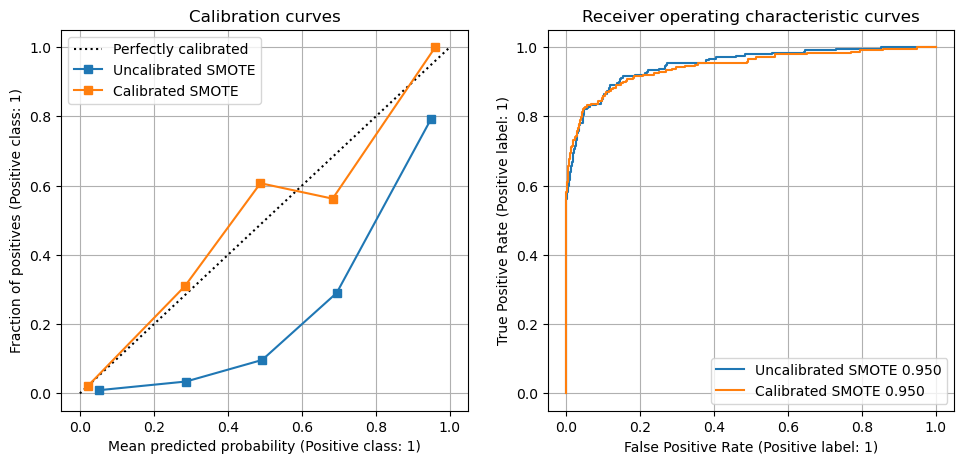

In [11]:
fig = plt.figure(figsize=(10,5))

# Calibration
ax1 = fig.add_subplot(121)
disp1 = CalibrationDisplay.from_estimator(
    model_smote, X_test, y_test, ax=ax1, n_bins=5, label='Uncalibrated SMOTE')
disp2 = CalibrationDisplay.from_estimator(
    calibrated_SMOTE_model, X_test, y_test, ax=ax1, n_bins=5, label='Calibrated SMOTE')
ax1.set_title('Calibration curves')
ax1.legend(loc='upper left')
ax1.grid()

# ROC
ax2 = fig.add_subplot(122)
auc = roc_auc_score(y_test, model_smote.predict_proba(X_test)[:,1])
disp1 = RocCurveDisplay.from_estimator(
    model_smote, X_test, y_test, ax=ax2, label=f'Uncalibrated SMOTE {auc:0.3f}')
auc = roc_auc_score(y_test, model_smote.predict_proba(X_test)[:,1])
disp1 = RocCurveDisplay.from_estimator(
    calibrated_SMOTE_model, X_test, y_test, ax=ax2, label=f'Calibrated SMOTE {auc:0.3f}')

ax2.set_title('Receiver operating characteristic curves')
ax2.grid()

plt.tight_layout(pad=2)
plt.show()

## Observations

Using under-sampling of the majority class, or over-sampling of the minority class (including use of SMOTE), significantly disrupts model calibration.

This effect could be especially significant if the model probabilities are being used to report risk, in which case over-sampling or under-sampling should be avoided, or the model recalibrated (which will lose the improved recall that comes by balancing the classes).